# 1. libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

! pip install ucimlrepo
! pip install category_encoders

from ucimlrepo import fetch_ucirepo

# 2. data preprossing

In [2]:
data = fetch_ucirepo(id=296)
X = data.data.features
y = data.data.targets

y_regression = X['time_in_hospital'].copy()
X_features = X.drop(columns=['time_in_hospital'])

df = X_features.copy()
df['readmitted'] = y['readmitted']

#### 2-1. Missing value and redundancy handling

In [3]:
df = df.drop(columns=['weight', 'payer_code'], errors='ignore')
df['medical_specialty'] = df['medical_specialty'].fillna('Other')
df['race'] = df['race'].fillna('Other')

diag_cols = ['diag_1', 'diag_2', 'diag_3']
df = df.dropna(subset=diag_cols)
y_regression = y_regression[df.index]

#### 2-2. Feature Engineering


In [4]:
numeric_cols = [
    'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses'
]

# Create interaction features
df['total_visits'] = df['number_outpatient'] + df['number_emergency'] + df['number_inpatient']
df['medical_intensity'] = df['num_lab_procedures'] + df['num_procedures'] + df['num_medications']
df['emergency_ratio'] = df['number_emergency'] / (df['number_outpatient'] + df['number_emergency'] + 1)
df['inpatient_ratio'] = df['number_inpatient'] / (df['total_visits'] + 1)
df['lab_to_med_ratio'] = df['num_lab_procedures'] / (df['num_medications'] + 1)
df['procedure_density'] = df['num_procedures'] / (df['num_lab_procedures'] + 1)

# Medication usage features
medication_cols = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone'
]

df['num_medications_used'] = df[medication_cols].apply(lambda row: sum(row != 'No'), axis=1)
df['uses_insulin'] = (df['insulin'] != 'No').astype(int)

# ICD-9 diagnosis grouping
def map_icd9(code):
    if pd.isna(code):
        return 'Other'
    code = str(code).strip()
    if code.startswith('V'):
        return 'Other'
    elif code.startswith('E'):
        return 'Injury'
    try:
        code_num = float(code)
    except ValueError:
        return 'Other'
    if 1 <= code_num <= 139: return 'Infectious'
    elif 140 <= code_num <= 239: return 'Neoplasms'
    elif 240 <= code_num <= 279: return 'Endocrine'
    elif 280 <= code_num <= 289: return 'Blood'
    elif 290 <= code_num <= 319: return 'Mental'
    elif 320 <= code_num <= 389: return 'Nervous'
    elif 390 <= code_num <= 459: return 'Circulatory'
    elif 460 <= code_num <= 519: return 'Respiratory'
    elif 520 <= code_num <= 579: return 'Digestive'
    elif 580 <= code_num <= 629: return 'Genitourinary'
    elif 630 <= code_num <= 679: return 'Pregnancy'
    elif 680 <= code_num <= 709: return 'Skin'
    elif 710 <= code_num <= 739: return 'Musculoskeletal'
    elif 740 <= code_num <= 759: return 'Congenital'
    elif 760 <= code_num <= 779: return 'Perinatal'
    elif 780 <= code_num <= 799: return 'Symptoms'
    elif 800 <= code_num <= 999: return 'Injury'
    else: return 'Other'

for col in diag_cols:
    df[col] = df[col].apply(map_icd9)

# Diagnosis-related features
serious_conditions = ['Circulatory', 'Respiratory', 'Neoplasms', 'Injury']
df['has_serious_condition'] = df[diag_cols].apply(
    lambda row: int(any(cond in serious_conditions for cond in row)), axis=1
)
df['unique_diagnoses'] = df[diag_cols].apply(lambda row: len(set(row)), axis=1)

# Age numeric conversion
age_mapping = {
    '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45,
    '[50-60)': 55, '[60-70)': 65, '[70-80)': 75, '[80-90)': 85, '[90-100)': 95
}
df['age_numeric'] = df['age'].map(age_mapping).fillna(55)

# Test result abnormality
df['has_glucose_abnormal'] = (df['max_glu_serum'] != 'None').astype(int)
df['has_A1C_abnormal'] = (df['A1Cresult'] != 'None').astype(int)


#### 2-3. Remove Data Leakage - Delete readmitted features

In [5]:
df['readmitted_30days'] = (df['readmitted'] == '<30').astype(int)  # REMOVED
df['readmitted_ever'] = (df['readmitted'] != 'NO').astype(int)

#### 2-4. Standardize numeric features

In [6]:
numeric_features = numeric_cols + [
    'total_visits', 'medical_intensity', 'emergency_ratio', 'inpatient_ratio',
    'lab_to_med_ratio', 'procedure_density', 'num_medications_used', 'age_numeric',
    'unique_diagnoses'
]

scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])


#### 2-5. Encode categorical features

In [7]:
categorical_cols = [
    'race', 'gender', 'admission_type_id', 'discharge_disposition_id',
    'admission_source_id', 'medical_specialty', 'max_glu_serum', 'A1Cresult',
    'change', 'diabetesMed',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
    'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
    'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
    'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
    'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone',
    'diag_1', 'diag_2', 'diag_3'
]

categorical_cols = [col for col in categorical_cols if col in df.columns]
data_final = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#### 2-6. Clean feature names

In [8]:
def clean_feature_names(df):
    col_mapping = {col: col.replace('[','_').replace(']','_').replace('<','_').replace(',','_') for col in df.columns}
    return df.rename(columns=col_mapping)

data_final = clean_feature_names(data_final)
data_final = data_final.drop(columns=['age', 'readmitted'], errors='ignore')

X = data_final
y = y_regression

# 3. Modelling

Train set: (80195, 250), Test set: (20049, 250)

Training LinearRegression

LinearRegression Performance:

   Train: RMSE=2.3028 | MAE=1.7443 | R²=0.4048
   Test:  RMSE=2.3162 | MAE=1.7543 | R²=0.4106
   Overfit: RMSE_diff=-0.0134, R²_diff=-0.0058
   Training time: 0.09 min

Training Ridge
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Ridge Performance:
   Best params: {'alpha': 10.0}

   Train: RMSE=2.3041 | MAE=1.7455 | R²=0.4041
   Test:  RMSE=2.3158 | MAE=1.7539 | R²=0.4108
   Overfit: RMSE_diff=-0.0117, R²_diff=-0.0067
   Training time: 0.11 min

Training RandomForest
Fitting 3 folds for each of 8 candidates, totalling 24 fits

RandomForest Performance:
   Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}

   Train: RMSE=1.9495 | MAE=1.4910 | R²=0.5734
   Test:  RMSE=2.3084 | MAE=1.7541 | R²=0.4146
   Overfit: RMSE_diff=-0.3589, R²_diff=+0.1588
   Training time: 14.12 min

Training XGBoost
Fitti

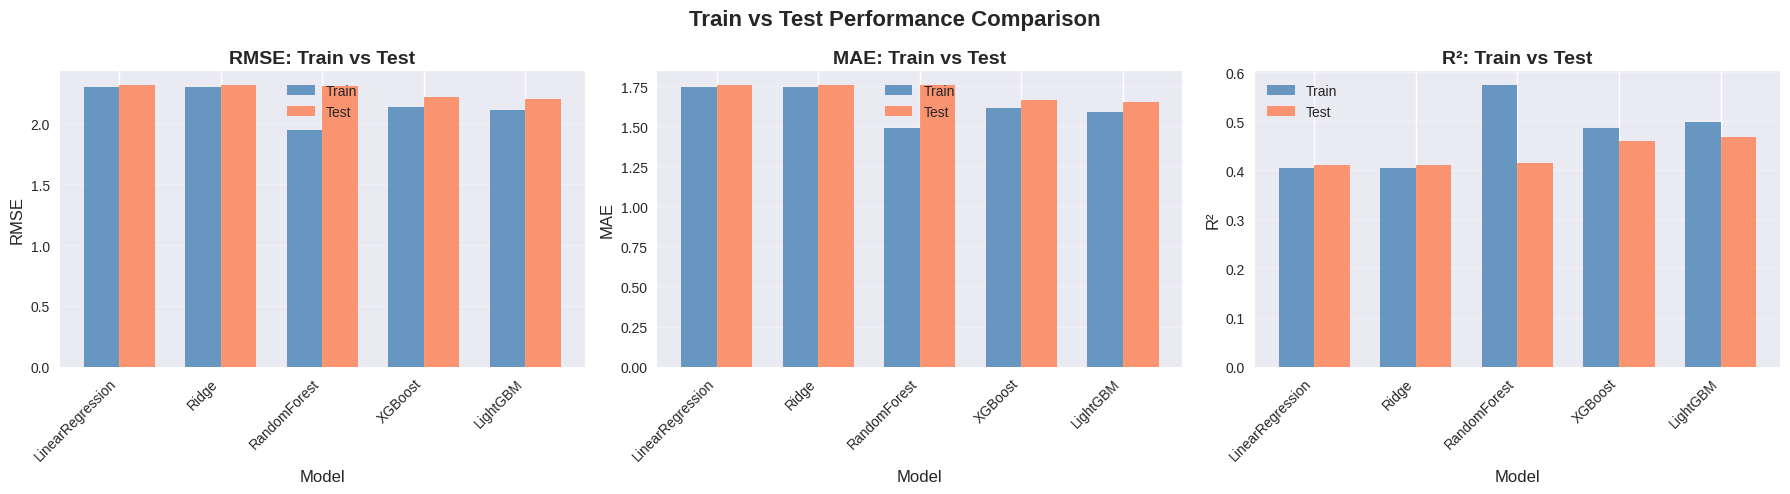

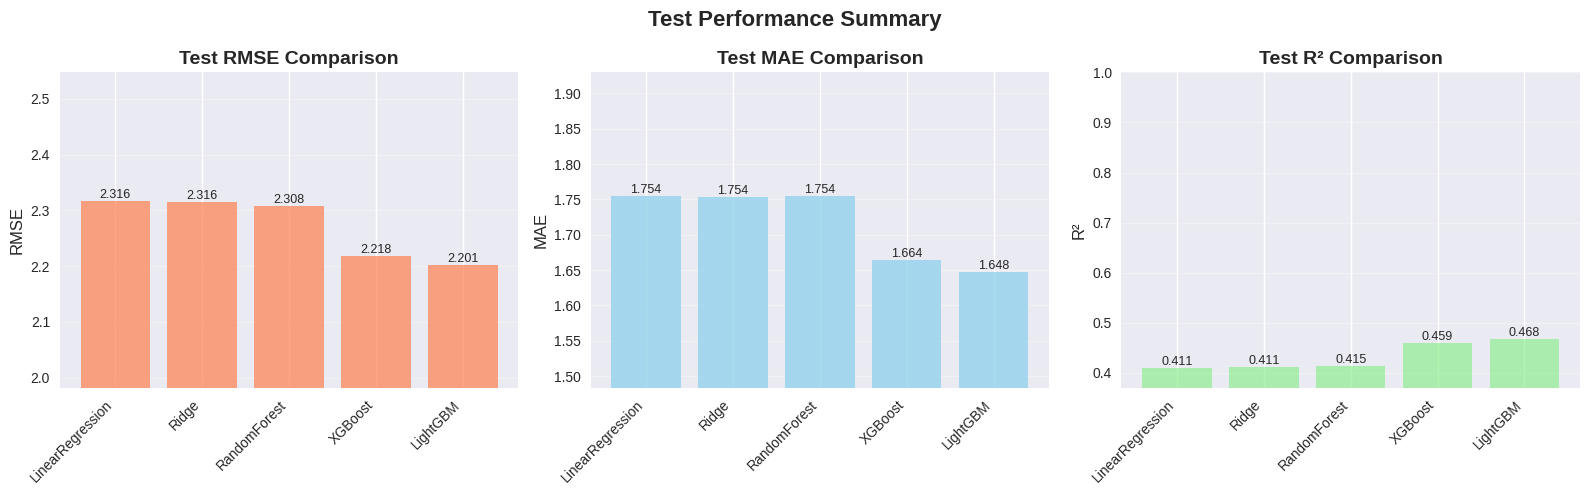


Generating LightGBM feature importance plot...


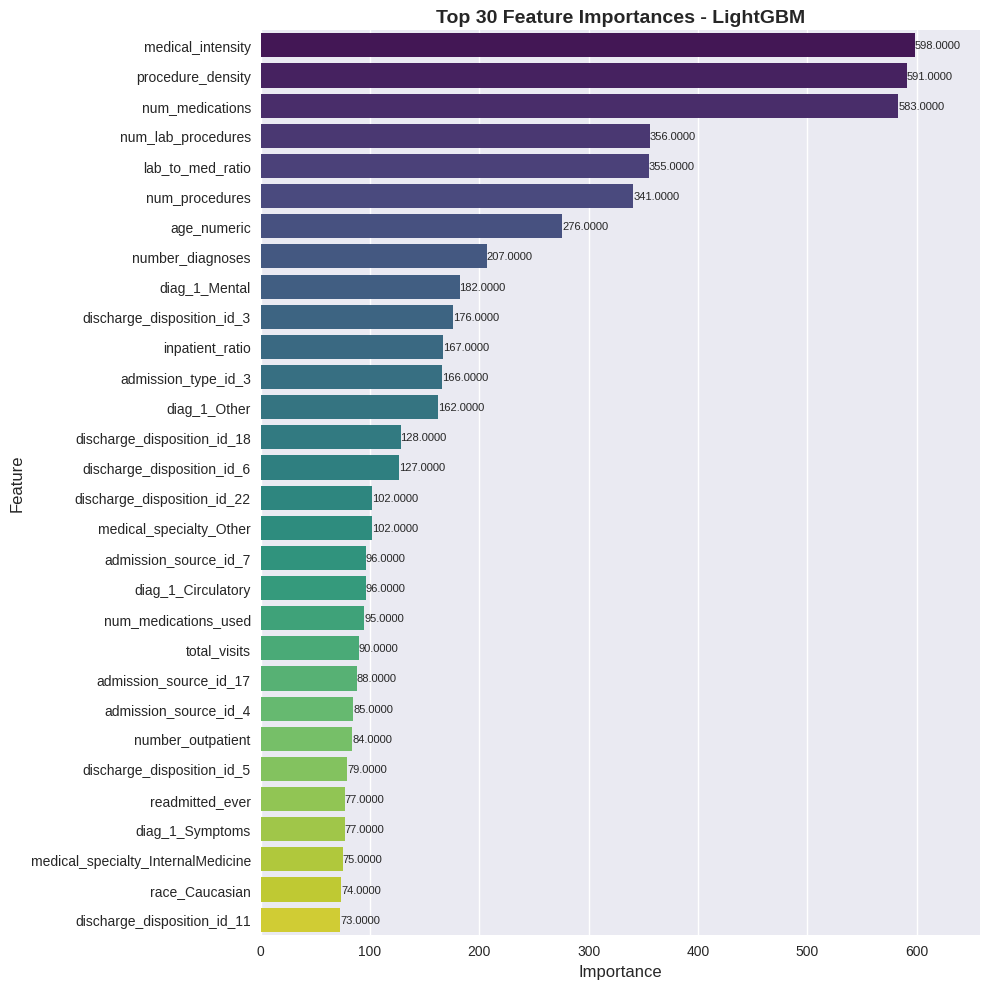


Top 15 Important Features:
                    feature  importance
          medical_intensity         598
          procedure_density         591
            num_medications         583
         num_lab_procedures         356
           lab_to_med_ratio         355
             num_procedures         341
                age_numeric         276
           number_diagnoses         207
              diag_1_Mental         182
 discharge_disposition_id_3         176
            inpatient_ratio         167
        admission_type_id_3         166
               diag_1_Other         162
discharge_disposition_id_18         128
 discharge_disposition_id_6         127

Analysis Complete! Total time: 21.13 min

 Key Findings:
   Best Model: LightGBM
   Test Performance: R²=0.4676, RMSE=2.2013
   Data leakage features removed
   Hyperparameters optimized with regularization
   Model complexity reduced for better generalization


In [9]:
# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

# Model and hyperparameter settings
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },

    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {'alpha': [0.1, 1.0, 10.0]}
    },


    'RandomForest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [300],
            'max_depth': [15, 20],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4],
            'max_features': ['sqrt']
        }
    },


    'XGBoost': {
        'model': XGBRegressor(
            random_state=42,
            n_jobs=-1,
            tree_method='hist'
        ),
        'params': {
            'n_estimators': [300],
            'max_depth': [4, 5],
            'learning_rate': [0.05],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'min_child_weight': [3, 5],
            'reg_alpha': [0.1, 0.5],
            'reg_lambda': [1]
        }
    },

    'LightGBM': {
        'model': LGBMRegressor(
            random_state=42,
            n_jobs=-1,
            verbose=-1
        ),
        'params': {
            'n_estimators': [300],
            'max_depth': [8, 10],
            'learning_rate': [0.05],
            'num_leaves': [25, 31],
            'subsample': [0.8],
            'min_child_samples': [20],
            'reg_alpha': [0.1, 0.5],
            'reg_lambda': [1]
        }
    }
}

results = {}
total_start = time.time()

for name, m in models.items():
    print(f"\n{'='*60}")
    print(f"Training {name}")
    print(f"{'='*60}")

    if len(m['params']) == 0:
        start = time.time()
        best_model = m['model']
        best_model.fit(X_train, y_train)
        elapsed = (time.time() - start) / 60
        best_params = {}
    else:
        grid = GridSearchCV(
            estimator=m['model'],
            param_grid=m['params'],
            cv=3,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )

        start = time.time()
        grid.fit(X_train, y_train)

        elapsed = (time.time() - start) / 60
        best_model = grid.best_estimator_
        best_params = grid.best_params_

    # Train set predictions
    y_train_pred = best_model.predict(X_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Test set predictions
    y_test_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Overfitting degree
    overfit_rmse = train_rmse - test_rmse
    overfit_r2 = train_r2 - test_r2

    print(f"\n{name} Performance:")
    if best_params:
        print(f"   Best params: {best_params}")
    print(f"\n   Train: RMSE={train_rmse:.4f} | MAE={train_mae:.4f} | R²={train_r2:.4f}")
    print(f"   Test:  RMSE={test_rmse:.4f} | MAE={test_mae:.4f} | R²={test_r2:.4f}")
    print(f"   Overfit: RMSE_diff={overfit_rmse:+.4f}, R²_diff={overfit_r2:+.4f}")
    print(f"   Training time: {elapsed:.2f} min")

    results[name] = {
        'model': best_model,
        'params': best_params,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'overfit_rmse': overfit_rmse,
        'overfit_r2': overfit_r2,
        'time': elapsed,
        'y_pred': y_test_pred
    }

total_elapsed = (time.time() - total_start) / 60

# Performance Comparison Table
comparison_df = pd.DataFrame({
    name: {
        'Train_RMSE': res['train_rmse'],
        'Test_RMSE': res['test_rmse'],
        'Train_MAE': res['train_mae'],
        'Test_MAE': res['test_mae'],
        'Train_R²': res['train_r2'],
        'Test_R²': res['test_r2'],
        'Overfit_RMSE': res['overfit_rmse'],
        'Overfit_R²': res['overfit_r2'],
        'Time (min)': res['time']
    }
    for name, res in results.items()
}).T

print("\n=== Complete Comparison Table ===")
print(comparison_df.round(4))

print("\n=== Overfitting Analysis ===")
for name in comparison_df.index:
    overfit_rmse = comparison_df.loc[name, 'Overfit_RMSE']
    overfit_r2 = comparison_df.loc[name, 'Overfit_R²']
    status = "Good" if (overfit_rmse > -0.3 and overfit_r2 < 0.1) else "Overfitting"
    print(f"{name:20s} - RMSE_diff: {overfit_rmse:+.4f}, R²_diff: {overfit_r2:+.4f} - {status}")

best_test_model = comparison_df['Test_RMSE'].idxmin()
print(f"\n Best Test Model: {best_test_model}")
print(f"   RMSE: {comparison_df.loc[best_test_model, 'Test_RMSE']:.4f}")
print(f"   R²: {comparison_df.loc[best_test_model, 'Test_R²']:.4f}")

# Visualization 1: Train vs Test Comparison
fig1, axes = plt.subplots(1, 3, figsize=(18, 5))

models_list = list(results.keys())
x_pos = np.arange(len(models_list))
bar_width = 0.35

# RMSE comparison
ax1 = axes[0]
train_rmse = [comparison_df.loc[m, 'Train_RMSE'] for m in models_list]
test_rmse = [comparison_df.loc[m, 'Test_RMSE'] for m in models_list]
ax1.bar(x_pos - bar_width/2, train_rmse, bar_width, label='Train', alpha=0.8, color='steelblue')
ax1.bar(x_pos + bar_width/2, test_rmse, bar_width, label='Test', alpha=0.8, color='coral')
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('RMSE: Train vs Test', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_list, rotation=45, ha='right')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3, axis='y')

# MAE comparison
ax2 = axes[1]
train_mae = [comparison_df.loc[m, 'Train_MAE'] for m in models_list]
test_mae = [comparison_df.loc[m, 'Test_MAE'] for m in models_list]
ax2.bar(x_pos - bar_width/2, train_mae, bar_width, label='Train', alpha=0.8, color='steelblue')
ax2.bar(x_pos + bar_width/2, test_mae, bar_width, label='Test', alpha=0.8, color='coral')
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('MAE: Train vs Test', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3, axis='y')

# R² comparison
ax3 = axes[2]
train_r2 = [comparison_df.loc[m, 'Train_R²'] for m in models_list]
test_r2 = [comparison_df.loc[m, 'Test_R²'] for m in models_list]
ax3.bar(x_pos - bar_width/2, train_r2, bar_width, label='Train', alpha=0.8, color='steelblue')
ax3.bar(x_pos + bar_width/2, test_r2, bar_width, label='Test', alpha=0.8, color='coral')
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('R²', fontsize=12)
ax3.set_title('R²: Train vs Test', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(models_list, rotation=45, ha='right')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3, axis='y')

plt.suptitle('Train vs Test Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualization 2: Test Performance Summary
fig2, axes = plt.subplots(1, 3, figsize=(16, 5))

# Test RMSE
ax1 = axes[0]
bars = ax1.bar(models_list, test_rmse, color='coral', alpha=0.7)
ax1.set_ylabel('RMSE', fontsize=12)
ax1.set_title('Test RMSE Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([min(test_rmse)*0.9, max(test_rmse)*1.1])
ax1.grid(axis='y', alpha=0.3)
ax1.set_xticklabels(models_list, rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Test MAE
ax2 = axes[1]
bars = ax2.bar(models_list, test_mae, color='skyblue', alpha=0.7)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('Test MAE Comparison', fontsize=14, fontweight='bold')
ax2.set_ylim([min(test_mae)*0.9, max(test_mae)*1.1])
ax2.grid(axis='y', alpha=0.3)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Test R²
ax3 = axes[2]
bars = ax3.bar(models_list, test_r2, color='lightgreen', alpha=0.7)
ax3.set_ylabel('R²', fontsize=12)
ax3.set_title('Test R² Comparison', fontsize=14, fontweight='bold')
ax3.set_ylim([min(test_r2)*0.9, 1.0])
ax3.grid(axis='y', alpha=0.3)
ax3.set_xticklabels(models_list, rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Test Performance Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualization 3: Best Model Feature Importance
best_model = results[best_test_model]['model']

if hasattr(best_model, 'feature_importances_'):
    print(f"\nGenerating {best_test_model} feature importance plot...")

    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values('importance', ascending=False).head(30)

    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y='feature', data=feat_imp, orient='h', palette='viridis')
    plt.title(f'Top 30 Feature Importances - {best_test_model}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.xlim([0, feat_imp['importance'].max() * 1.1])

    for i, (idx, row) in enumerate(feat_imp.iterrows()):
        plt.text(row['importance'] + 0.001, i, f"{row['importance']:.4f}",
                va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

    print("\nTop 15 Important Features:")
    print(feat_imp.head(15).to_string(index=False))

elif hasattr(best_model, 'coef_'):
    print(f"\nGenerating {best_test_model} coefficient importance plot...")

    coef_abs = np.abs(best_model.coef_)
    feat_imp = pd.DataFrame({
        'feature': X_train.columns,
        'importance': coef_abs
    }).sort_values('importance', ascending=False).head(30)

    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y='feature', data=feat_imp, orient='h', palette='viridis')
    plt.title(f'Top 30 Coefficient Magnitudes - {best_test_model}',
              fontsize=14, fontweight='bold')
    plt.xlabel('|Coefficient|', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

    print("\nTop 15 Important Features:")
    print(feat_imp.head(15).to_string(index=False))

# Summary
print(f"\n{'='*60}")
print(f"Analysis Complete! Total time: {total_elapsed:.2f} min")
print(f"\n Key Findings:")
print(f"   Best Model: {best_test_model}")
print(f"   Test Performance: R²={comparison_df.loc[best_test_model, 'Test_R²']:.4f}, "
      f"RMSE={comparison_df.loc[best_test_model, 'Test_RMSE']:.4f}")
print(f"   Data leakage features removed")
print(f"   Hyperparameters optimized with regularization")
print(f"   Model complexity reduced for better generalization")
print(f"{'='*60}")